# UK Electricity Market Simulation
## Pay-as-Clear Auction Dispatch Algorithm

**Author:** Yulin Zhang  
**Date:** 15th December 2025  
**Assessment:** Quantitative Development Intern Technical Assessment

---

## Table of Contents

1. [Introduction & Problem Statement](#1-introduction--problem-statement)
2. [Methodology](#2-methodology)
3. [Data Loading & Exploration](#3-data-loading--exploration)
4. [Implementation](#4-implementation)
5. [Simulation Results](#5-simulation-results)
6. [Visualizations](#6-visualizations)
7. [Summary & Key Insights](#7-summary--key-insights)

---

## 1. Introduction & Problem Statement

This notebook is about the simulation of the **UK electricity market's pay-as-clear auction mechanism** to compute hourly electricity prices and analyse the generation mix.

### Objective
- Simulate the dispatch algorithm used by the System Operator (SO)
- Calculate the **marginal price** of electricity for each hour
- Determine optimal generator dispatch based on merit order
- Provide a breakdown of **wind, solar, and gas generation** dispatched each hour

### Key Assumptions
- Wind and solar have **£0/MWh marginal cost** (no fuel costs)
- Gas plants' costs are varied which depend on **gas price** and **plant efficiency**
- All generators receive the **marginal price** (pay-as-clear)
- Load factors for renewables are known
- Conversion factor: **1 MWh = 34.121 Therms**

---

## 2. Methodology

This section outlines the pay-as-clear auction mechanism and the dispatch algorithm used in the simulation.

### 2.1 Merit Order Concept

The merit order ranks generators by marginal cost (lowest to highest). Generators are dispatched in this order until demand is met. The **last generator dispatched sets the clearing price** for all.

![Merit Order Example](../images/Merit_Order_Example__How_Marginal_Price_is_Determined.png)

### 2.2 Dispatch Algorithm

The flowchart below shows the step-by-step process for each hour:

![Dispatch Flowchart](../images/UK_Electricity_Market_Dispatch_Algorithm_-_Step-by-Step_Process.png)


### 2.3 Key Formulas

**Gas Plant Marginal Cost:**

$$\text{Marginal Cost (£/MWh)} = \frac{\text{Gas Price (GBp/Therm)} \times 34.121}{\text{Efficiency} \times 100}$$

**Available Renewable Capacity:**

$$\text{Available (MW)} = \text{Capacity (MW)} \times \text{Load Factor}$$

---

## 3. Data Loading & Exploration

This section is to load and validate the input data, then explore key patterns that will influence the simulation results.

### 3.1 Import Libraries & Load Data

In [50]:
"""
Imports and Configuration
-------------------------
Set up all required libraries and define constants used throughout the simulation.
"""

# Standard library
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, Tuple, List
import warnings

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Pandas display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

# Plot styling
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

# Constants from Assessment Brief

# Conversion factor: 1 MWh of energy equals 34.121 Therms of gas
therm_to_mwh = 34.121

# Green Energy (GE) generators (wind and solar) have zero marginal cost since they don't need to purchase fuel
ge_marginal_cost = 0.0

# Gas prices are given in pence, so we need to convert to pounds for final output
pence_to_pounds = 100

print("Libraries loaded successfully")

Libraries loaded successfully


In [3]:
"""
Data Loading
------------
Load all sheets from the Excel file into a structured dictionary.
The assessment provides data across 7 sheets, each containing different
market information needed for the dispatch simulation.
"""

def load_data(filepath: str) -> Dict[str, pd.DataFrame]:
    """
    Load electricity market data from the provided Excel file.
    
    The Excel file contains the following sheets:
    - windplants: Name and capacity of each wind plant
    - wind_loadfactors: Hourly load factors for each wind plant
    - solarplants: name and capacity of each solar plant  
    - solar_loadfactors: Hourly load factors for each solar plant
    - gasplants: Name, capacity, and efficiency of each gas plant
    - demand: Hourly electricity demand
    - gas_prices: Hourly gas prices in GBp/Therm
    
    Parameters
    ----------
    filepath : str
        Path to the Excel file
        
    Returns
    -------
    Dict[str, pd.DataFrame]
        Dictionary containing all data tables
    """
    # Check file exists before attempting to load
    file_path = Path(filepath)
    if not file_path.exists():
        raise FileNotFoundError(f"Data file not found: {filepath}")
    
    # Load Excel file
    xlsx = pd.ExcelFile(filepath)
    
    # Expected sheets based on assessment documentation
    expected_sheets = [
        'windplants', 'wind_loadfactors', 'solarplants', 
        'solar_loadfactors', 'gasplants', 'demand', 'gas_prices'
    ]
    
    # Verify all required sheets are present
    missing = set(expected_sheets) - set(xlsx.sheet_names)
    if missing:
        raise ValueError(f"Missing required sheets: {missing}")
    
    # Load each sheet into dictionary
    data = {
        'wind_plants': pd.read_excel(xlsx, sheet_name='windplants'),
        'wind_loadfactors': pd.read_excel(xlsx, sheet_name='wind_loadfactors'),
        'solar_plants': pd.read_excel(xlsx, sheet_name='solarplants'),
        'solar_loadfactors': pd.read_excel(xlsx, sheet_name='solar_loadfactors'),
        'gas_plants': pd.read_excel(xlsx, sheet_name='gasplants'),
        'demand': pd.read_excel(xlsx, sheet_name='demand'),
        'gas_prices': pd.read_excel(xlsx, sheet_name='gas_prices')
    }
    
    return data


# Load the data
data_path = '../data/data 2.xlsx'
elec_data = load_data(data_path)

# Extract individual dataframes for convenient access
wind_plants = elec_data['wind_plants']
wind_loadfactors = elec_data['wind_loadfactors']
solar_plants = elec_data['solar_plants']
solar_loadfactors = elec_data['solar_loadfactors']
gas_plants = elec_data['gas_plants']
demand = elec_data['demand']
gas_prices = elec_data['gas_prices']

print(f"Data loaded: {list(elec_data.keys())}")

Data loaded: ['wind_plants', 'wind_loadfactors', 'solar_plants', 'solar_loadfactors', 'gas_plants', 'demand', 'gas_prices']


### 3.2 Data Overview

In [5]:
"""
Data Overview
-------------
Display summary of all loaded data to understand the structure.
"""

def display_data_overview(data: Dict[str, pd.DataFrame]) -> None:
    """
    Print a comprehensive overview of the market data.
    """
    print("DATA OVERVIEW")
    
    # Wind plants
    print("\nWIND PLANTS")
    print("-" * 40)
    print(data['wind_plants'].to_string(index=False))
    total_wind = data['wind_plants']['capacity'].sum()
    print(f"\nTotal wind capacity: {total_wind:,} MW")
    
    # Solar plants
    print("\nSOLAR PLANTS")
    print("-" * 40)
    print(data['solar_plants'].to_string(index=False))
    total_solar = data['solar_plants']['capacity'].sum()
    print(f"\nTotal solar capacity: {total_solar:,} MW")
    
    # Gas plants
    print("\nGAS PLANTS")
    print("-" * 40)
    print(data['gas_plants'].to_string(index=False))
    total_gas = data['gas_plants']['capacity'].sum()
    print(f"\nTotal gas capacity: {total_gas:,} MW")
    eff_range = data['gas_plants']['efficiency']
    print(f"Efficiency range: {eff_range.min():.0%} - {eff_range.max():.0%}")
    
    # Time series info
    n_hours = len(data['demand'])
    print("\nTIME SERIES")
    print("-" * 40)
    print(f"Total hours: {n_hours} ({n_hours // 24} days)")
    
    # Demand statistics
    demand_col = data['demand']['demand']
    print(f"\nDemand range: {demand_col.min():,.0f} - {demand_col.max():,.0f} MWh")
    print(f"Average demand: {demand_col.mean():,.0f} MWh")
    
    # Gas price statistics
    price_col = data['gas_prices']['price']
    print(f"\nGas price range: {price_col.min():.0f} - {price_col.max():.0f} GBp/Therm")
    print(f"Average gas price: {price_col.mean():.1f} GBp/Therm")
    
    # Total capacity summary
    total_capacity = total_wind + total_solar + total_gas
    print("\nCAPACITY SUMMARY")
    print("-" * 40)
    print(f"Wind:  {total_wind:>10,} MW  ({total_wind/total_capacity:>5.1%})")
    print(f"Solar: {total_solar:>10,} MW  ({total_solar/total_capacity:>5.1%})")
    print(f"Gas:   {total_gas:>10,} MW  ({total_gas/total_capacity:>5.1%})")
    print(f"Total: {total_capacity:>10,} MW")


display_data_overview(elec_data)

DATA OVERVIEW

WIND PLANTS
----------------------------------------
 name  capacity
wind1      2500
wind2      3000
wind3      3500
wind4      4000
wind5      4500
wind6      5000

Total wind capacity: 22,500 MW

SOLAR PLANTS
----------------------------------------
   name  capacity
 solar1      1700
 solar2      1900
 solar3      2100
 solar4      2300
 solar5      2500
 solar6      2700
 solar7      2900
 solar8      3100
 solar9      3300
solar10      3500

Total solar capacity: 26,000 MW

GAS PLANTS
----------------------------------------
name  capacity  efficiency
gas1      2500        0.35
gas2      3000        0.40
gas3      3500        0.45
gas4      4000        0.50
gas5      4500        0.55

Total gas capacity: 17,500 MW
Efficiency range: 35% - 55%

TIME SERIES
----------------------------------------
Total hours: 168 (7 days)

Demand range: 17,434 - 30,541 MWh
Average demand: 24,108 MWh

Gas price range: 70 - 99 GBp/Therm
Average gas price: 87.4 GBp/Therm

CAPACITY SUMMAR

### 3.3 Data Validation

In [8]:
"""
Data Validation
---------------
Perform quality checks to ensure data integrity before running the simulation.
"""

def validate_data(data: Dict[str, pd.DataFrame]) -> Tuple[bool, List[str]]:
    """
    Validate market data for completeness and consistency.
    
    Checks performed:
    1. No missing values in any table
    2. Load factors are within valid range [0, 1]
    3. Gas plant efficiencies are within realistic range (0, 1)
    4. All capacities, demand, and prices are positive
    5. Time series are consistent (same number of hours)
    6. Plant names match between capacity tables and load factor tables
    7. Total capacity is sufficient to meet maximum demand
    
    Parameters
    ----------
    data : Dict[str, pd.DataFrame]
        Dictionary containing all market data
        
    Returns
    -------
    Tuple[bool, List[str]]
        - bool: True if all validations pass, False otherwise
        - List[str]: List of any issues found (errors or warnings)
    """
    issues = []
    
    print("DATA VALIDATION")
    
    # Check 1: Missing values
    print("\n1. Missing Values Check")
    for name, df in data.items():
        missing = df.isnull().sum().sum()
        if missing > 0:
            issues.append(f"{name}: {missing} missing values")
            print(f"   FAIL - {name}: {missing} missing values")
        else:
            print(f"   OK - {name}")
    
    # Check 2: Load factor ranges (must be between 0 and 1)
    print("\n2. Load Factor Range Check [0, 1]")
    
    wind_lf_cols = [c for c in data['wind_loadfactors'].columns if c != 'hour']
    wind_lf_vals = data['wind_loadfactors'][wind_lf_cols].values
    if wind_lf_vals.min() < 0 or wind_lf_vals.max() > 1:
        issues.append(f"Wind load factors out of range: [{wind_lf_vals.min():.4f}, {wind_lf_vals.max():.4f}]")
        print(f"   FAIL - Wind: [{wind_lf_vals.min():.4f}, {wind_lf_vals.max():.4f}]")
    else:
        print(f"   OK - Wind: [{wind_lf_vals.min():.4f}, {wind_lf_vals.max():.4f}]")
    
    solar_lf_cols = [c for c in data['solar_loadfactors'].columns if c != 'hour']
    solar_lf_vals = data['solar_loadfactors'][solar_lf_cols].values
    if solar_lf_vals.min() < 0 or solar_lf_vals.max() > 1:
        issues.append(f"Solar load factors out of range: [{solar_lf_vals.min():.4f}, {solar_lf_vals.max():.4f}]")
        print(f"   FAIL - Solar: [{solar_lf_vals.min():.4f}, {solar_lf_vals.max():.4f}]")
    else:
        print(f"   OK - Solar: [{solar_lf_vals.min():.4f}, {solar_lf_vals.max():.4f}]")
    
    # Check 3: Gas efficiency range
    print("\n3. Gas Efficiency Range Check (0, 1)")
    eff = data['gas_plants']['efficiency']
    if eff.min() <= 0 or eff.max() >= 1:
        issues.append(f"Gas efficiency out of valid range: [{eff.min()}, {eff.max()}]")
        print(f"   FAIL - Range: [{eff.min():.2f}, {eff.max():.2f}]")
    else:
        print(f"   OK - Range: [{eff.min():.2f}, {eff.max():.2f}]")
    
    # Check 4: Positive values
    print("\n4. Positive Values Check")
    
    for plant_type in ['wind_plants', 'solar_plants', 'gas_plants']:
        if data[plant_type]['capacity'].min() <= 0:
            issues.append(f"{plant_type}: non-positive capacity found")
            print(f"   FAIL - {plant_type} capacity")
        else:
            print(f"   OK - {plant_type} capacity")
    
    if data['demand']['demand'].min() <= 0:
        issues.append("Non-positive demand values found")
        print("   FAIL - demand")
    else:
        print("   OK - demand")
    
    if data['gas_prices']['price'].min() <= 0:
        issues.append("Non-positive gas price values found")
        print("   FAIL - gas prices")
    else:
        print("   OK - gas prices")
    
    # Check 5: Time series alignment
    print("\n5. Time Series Alignment Check")
    n_demand = len(data['demand'])
    n_wind_lf = len(data['wind_loadfactors'])
    n_solar_lf = len(data['solar_loadfactors'])
    n_gas_prices = len(data['gas_prices'])
    
    if not (n_demand == n_wind_lf == n_solar_lf == n_gas_prices):
        issues.append(f"Hour count mismatch: {n_demand}, {n_wind_lf}, {n_solar_lf}, {n_gas_prices}")
        print(f"   FAIL - Counts: {n_demand}, {n_wind_lf}, {n_solar_lf}, {n_gas_prices}")
    else:
        print(f"   OK - All tables have {n_demand} hours")
    
    # Check 6: Plant name consistency
    print("\n6. Plant Name Consistency Check")
    
    wind_names = set(data['wind_plants']['name'])
    wind_lf_names = set(data['wind_loadfactors'].columns) - {'hour'}
    if wind_names != wind_lf_names:
        issues.append("Wind plant names don't match between tables")
        print("   FAIL - Wind plant names mismatch")
    else:
        print(f"   OK - Wind: {len(wind_names)} plants match")
    
    solar_names = set(data['solar_plants']['name'])
    solar_lf_names = set(data['solar_loadfactors'].columns) - {'hour'}
    if solar_names != solar_lf_names:
        issues.append("Solar plant names don't match between tables")
        print("   FAIL - Solar plant names mismatch")
    else:
        print(f"   OK - Solar: {len(solar_names)} plants match")
    
    # Check 7: Supply adequacy
    print("\n7. Supply Adequacy Check")
    total_cap = (
        data['wind_plants']['capacity'].sum() +
        data['solar_plants']['capacity'].sum() +
        data['gas_plants']['capacity'].sum()
    )
    max_demand = data['demand']['demand'].max()
    
    if total_cap < max_demand:
        issues.append(f"Insufficient capacity: {total_cap:,} MW < {max_demand:,} MW demand")
        print(f"   WARNING - Capacity ({total_cap:,} MW) < Max demand ({max_demand:,} MW)")
    else:
        margin = (total_cap - max_demand) / max_demand * 100
        print(f"   OK - Capacity margin: {margin:.1f}%")
    
    # Summary
    print("-" * 40)
    is_valid = len(issues) == 0
    if is_valid:
        print("VALIDATION PASSED - All checks OK")
    else:
        print(f"VALIDATION FAILED - {len(issues)} issue(s) found")
        for issue in issues:
            print(f"  - {issue}")
    
    return is_valid, issues


is_valid, validation_issues = validate_data(elec_data)

DATA VALIDATION

1. Missing Values Check
   OK - wind_plants
   OK - wind_loadfactors
   OK - solar_plants
   OK - solar_loadfactors
   OK - gas_plants
   OK - demand
   OK - gas_prices

2. Load Factor Range Check [0, 1]
   OK - Wind: [0.0002, 0.9470]
   OK - Solar: [0.0000, 0.7964]

3. Gas Efficiency Range Check (0, 1)
   OK - Range: [0.35, 0.55]

4. Positive Values Check
   OK - wind_plants capacity
   OK - solar_plants capacity
   OK - gas_plants capacity
   OK - demand
   OK - gas prices

5. Time Series Alignment Check
   OK - All tables have 168 hours

6. Plant Name Consistency Check
   OK - Wind: 6 plants match
   OK - Solar: 10 plants match

7. Supply Adequacy Check
   OK - Capacity margin: 116.1%
----------------------------------------
VALIDATION PASSED - All checks OK


### 3.4 Exploratory Analysis

**Demand Pattern:**
- Clear diurnal (daily) cycle with peaks during daytime and troughs at night
- Demand ranges from approximately 17,400 MWh to 30,500 MWh
- Average demand of ~24,100 MWh suggests significant baseload requirement

**Gas Price Trend:**
- Prices show an upward trend over the 7-day period (70 to ~95 GBp/Therm)
- This will directly impact gas plant marginal costs and likely push electricity prices higher towards the end of the simulation period

**Wind Availability:**
- Highly variable with no clear daily pattern
- Load factors range from near-zero to over 90% at times
- The variability means wind contribution will fluctuate significantly hour-to-hour

**Solar Availability:**
- Strong diurnal pattern following daylight hours (zero at night, peak at midday)
- Maximum load factors around 50-70%
- Solar generation will only contribute during approximately 10-12 hours per day

**Implications for Dispatch:**
- Night-time hours will rely heavily on wind and gas (no solar)
- High-demand daytime hours with good solar/wind could see lower prices
- As gas prices rise through the week, we expect electricity prices to follow when gas plants are marginal

Figure saved to: ../results/01_exploratory_analysis.png


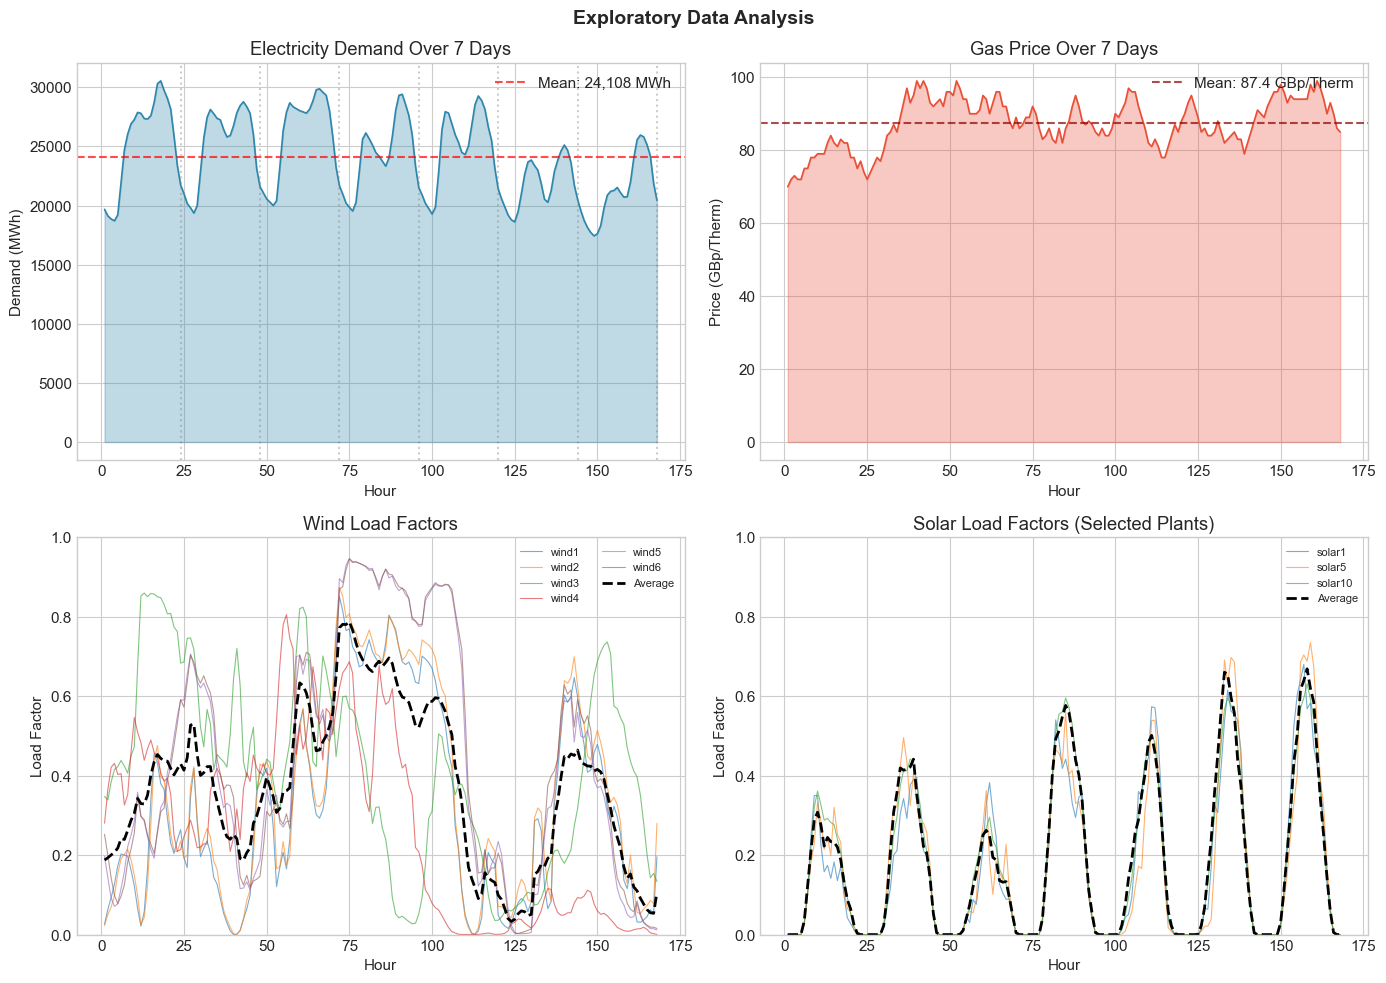

In [10]:
"""
Exploratory Visualizations
--------------------------
Create plots to understand data patterns before running the simulation.
"""

def plot_exploratory_analysis(data: Dict[str, pd.DataFrame], save_path: str = None) -> None:
    """
    Generate exploratory plots for the market data.
    
    Creates a 2x2 figure showing:
    - Top left: Demand profile over 7 days
    - Top right: Gas price variation
    - Bottom left: Wind load factors
    - Bottom right: Solar load factors
    
    Parameters
    ----------
    data : Dict[str, pd.DataFrame]
        Market data dictionary
    save_path : str, optional
        Path to save the figure. If None, figure is not saved.
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Exploratory Data Analysis', fontsize=14, fontweight='bold')
    
    hours = data['demand']['hour']
    
    # Plot 1: Demand profile
    ax1 = axes[0, 0]
    ax1.plot(hours, data['demand']['demand'], color='#2E86AB', linewidth=1.2)
    ax1.fill_between(hours, data['demand']['demand'], alpha=0.3, color='#2E86AB')
    ax1.set_xlabel('Hour')
    ax1.set_ylabel('Demand (MWh)')
    ax1.set_title('Electricity Demand Over 7 Days')
    ax1.axhline(y=data['demand']['demand'].mean(), color='red', linestyle='--', 
                alpha=0.7, label=f"Mean: {data['demand']['demand'].mean():,.0f} MWh")
    ax1.legend(loc='upper right')
    
    # Add vertical lines to mark day boundaries
    for day in range(1, 8):
        ax1.axvline(x=day * 24, color='gray', linestyle=':', alpha=0.4)
    
    # Plot 2: Gas prices
    ax2 = axes[0, 1]
    ax2.plot(hours, data['gas_prices']['price'], color='#E94F37', linewidth=1.2)
    ax2.fill_between(hours, data['gas_prices']['price'], alpha=0.3, color='#E94F37')
    ax2.set_xlabel('Hour')
    ax2.set_ylabel('Price (GBp/Therm)')
    ax2.set_title('Gas Price Over 7 Days')
    ax2.axhline(y=data['gas_prices']['price'].mean(), color='darkred', linestyle='--',
                alpha=0.7, label=f"Mean: {data['gas_prices']['price'].mean():.1f} GBp/Therm")
    ax2.legend(loc='upper right')
    
    # Plot 3: Wind load factors
    ax3 = axes[1, 0]
    wind_cols = [c for c in data['wind_loadfactors'].columns if c != 'hour']
    
    for col in wind_cols:
        ax3.plot(hours, data['wind_loadfactors'][col], alpha=0.6, linewidth=0.8, label=col)
    
    # Show average as bold line
    avg_wind = data['wind_loadfactors'][wind_cols].mean(axis=1)
    ax3.plot(hours, avg_wind, color='black', linewidth=2, linestyle='--', label='Average')
    
    ax3.set_xlabel('Hour')
    ax3.set_ylabel('Load Factor')
    ax3.set_title('Wind Load Factors')
    ax3.set_ylim(0, 1)
    ax3.legend(loc='upper right', fontsize=8, ncol=2)
    
    # Plot 4: Solar load factors
    ax4 = axes[1, 1]
    solar_cols = [c for c in data['solar_loadfactors'].columns if c != 'hour']
    
    # Plot a few representative plants for clarity
    for col in ['solar1', 'solar5', 'solar10']:
        ax4.plot(hours, data['solar_loadfactors'][col], alpha=0.6, linewidth=0.8, label=col)
    
    # Show average
    avg_solar = data['solar_loadfactors'][solar_cols].mean(axis=1)
    ax4.plot(hours, avg_solar, color='black', linewidth=2, linestyle='--', label='Average')
    
    ax4.set_xlabel('Hour')
    ax4.set_ylabel('Load Factor')
    ax4.set_title('Solar Load Factors (Selected Plants)')
    ax4.set_ylim(0, 1)
    ax4.legend(loc='upper right', fontsize=8)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Figure saved to: {save_path}")
    
    plt.show()


# Generate and save exploratory plots
plot_exploratory_analysis(elec_data, save_path='../results/01_exploratory_analysis.png')

## 4. Implementation

The dispatch simulation follows three steps for each hour:

1. **Calculate gas plant costs** - Convert gas price and plant efficiency into £/MWh bid prices
2. **Build merit order** - Rank all generators by cost (renewables at £0, then gas by efficiency)
3. **Dispatch generators** - Work through the merit order until demand is met; the last generator needed sets the clearing price

### 4.1 Gas Plant Marginal Cost Calculation

In [14]:
"""
Gas Plant Marginal Cost Calculation
-----------------------------------
Gas plants need to buy fuel to generate electricity, so their marginal cost
depends on the gas price and how efficiently they convert gas to electricity.

Formula derivation:
- Gas plants burn gas to produce electricity
- Cost depends on: (1) how much gas is needed, (2) price of gas
- Gas needed = Energy output / Efficiency
- For 1 MWh output: Gas needed = 1 / Efficiency (in MWh of gas energy)
- Converting to Therms: 1 MWh = 34.121 Therms
- Gas needed (Therms) = 34.121 / Efficiency
- Cost (pence) = Gas needed × Gas price (pence/Therm)
- Cost (£) = Cost (pence) / 100

Marginal Cost (£/MWh) = (Gas Price in pence × 34.121) / (Efficiency × 100)
"""

def calculate_gas_marginal_cost(gas_price_pence: float, efficiency: float) -> float:
    """
    Calculate the cost for a gas plant to produce 1 MWh of electricity.
    
    This is the plant's "bid price" - the minimum price it needs to break even.
    Lower efficiency means more gas burned, which means higher cost.
    
    Parameters
    ----------
    gas_price_pence : float
        Gas price in pence per Therm
    efficiency : float
        Plant efficiency (e.g., 0.45 means 45% of gas energy becomes electricity)
        
    Returns
    -------
    float
        Cost in £/MWh
    """
    therms_needed = therm_to_mwh / efficiency
    cost_pence = therms_needed * gas_price_pence
    cost_pounds = cost_pence / pence_to_pounds
    return cost_pounds


def calculate_all_gas_costs(gas_plants_df: pd.DataFrame, gas_price_pence: float) -> pd.DataFrame:
    """
    Calculate marginal costs for all gas plants at a given gas price.
    
    Returns a copy of the input dataframe with an added 'marginal_cost' column.
    """
    result = gas_plants_df.copy()
    result['marginal_cost'] = result['efficiency'].apply(
        lambda eff: calculate_gas_marginal_cost(gas_price_pence, eff)
    )
    return result

In [15]:
"""
Quick Test - Gas Marginal Cost
"""

# Test with sample gas price
sample_gas_price = 80  # pence per therm

gas_costs_demo = calculate_all_gas_costs(gas_plants, sample_gas_price)
print(f"Gas costs at {sample_gas_price} GBp/Therm:\n")
print(gas_costs_demo.to_string(index=False))

Gas costs at 80 GBp/Therm:

name  capacity  efficiency  marginal_cost
gas1      2500        0.35        77.9909
gas2      3000        0.40        68.2420
gas3      3500        0.45        60.6596
gas4      4000        0.50        54.5936
gas5      4500        0.55        49.6305


### 4.2 Build Merit Order for Each Hour

In [16]:
"""
Merit Order Construction

The merit order ranks all generators by their bid price, cheapest first.
This determines who gets dispatched: we start at the top and work down
until we have enough generation to meet demand.

For renewables (wind and solar):
- Bid price is £0 (no fuel cost)
- Available capacity = max capacity × load factor for that hour

For gas plants:
- Bid price = marginal cost calculated above
- Full capacity is always available (they can turn on whenever)
"""

def get_renewable_availability(
    plants_df: pd.DataFrame,
    loadfactors_df: pd.DataFrame,
    hour: int
) -> pd.DataFrame:
    """
    Calculate how much renewable capacity is actually available this hour.
    
    Available capacity = Maximum capacity × Load factor
    """
    hour_idx = hour - 1  # Convert to zero-based index
    result = plants_df.copy()
    
    # Look up load factor for each plant and multiply by capacity
    available = []
    for _, plant in plants_df.iterrows():
        load_factor = loadfactors_df.loc[hour_idx, plant['name']]
        available.append(plant['capacity'] * load_factor)
    
    result['available_capacity'] = available
    result['marginal_cost'] = ge_marginal_cost # £0 for green energy
    
    return result


def build_merit_order(
    wind_plants_df: pd.DataFrame,
    wind_lf_df: pd.DataFrame,
    solar_plants_df: pd.DataFrame,
    solar_lf_df: pd.DataFrame,
    gas_plants_df: pd.DataFrame,
    gas_price_pence: float,
    hour: int
) -> pd.DataFrame:
    """
    Build the merit order for a specific hour.
    
    Combines all generators with their costs and available capacity,
    then sorts by cost so we know what order to dispatch them in.
    """
    # Get wind availability (capacity × load factor)
    wind = get_renewable_availability(wind_plants_df, wind_lf_df, hour)
    wind['type'] = 'wind'
    
    # Get solar availability
    solar = get_renewable_availability(solar_plants_df, solar_lf_df, hour)
    solar['type'] = 'solar'
    
    # Gas plants can always run at full capacity, just need to calculate costs
    gas = calculate_all_gas_costs(gas_plants_df, gas_price_pence)
    gas['type'] = 'gas'
    gas['available_capacity'] = gas['capacity']
    
    # Combine everything into one table
    columns = ['name', 'type', 'capacity', 'available_capacity', 'marginal_cost']
    merit_order = pd.concat([
        wind[columns],
        solar[columns],
        gas[columns]
    ], ignore_index=True)
    
    # Sort by marginal cost (ascending) to create merit order
    merit_order = merit_order.sort_values('marginal_cost', kind='stable').reset_index(drop=True)
    
    return merit_order

In [17]:
"""
Quick Test - Merit Order
"""

demo_hour = 12
demo_gas_price = gas_prices.loc[demo_hour - 1, 'price']
demo_demand = demand.loc[demo_hour - 1, 'demand']

merit_order_demo = build_merit_order(
    wind_plants, wind_loadfactors,
    solar_plants, solar_loadfactors,
    gas_plants, demo_gas_price,
    demo_hour
)

print(f"Merit Order for Hour {demo_hour} (demand: {demo_demand:,.0f} MWh)\n")
print(merit_order_demo.to_string(index=False))

Merit Order for Hour 12 (demand: 27,797 MWh)

   name  type  capacity  available_capacity  marginal_cost
  wind1  wind      2500             53.0133         0.0000
  wind2  wind      3000             76.3561         0.0000
  wind3  wind      3500           2983.3115         0.0000
  wind4  wind      4000           1933.3138         0.0000
  wind5  wind      4500           1336.6224         0.0000
  wind6  wind      5000           1490.5597         0.0000
 solar1 solar      1700            268.7275         0.0000
 solar2 solar      1900            364.6201         0.0000
 solar3 solar      2100            563.3334         0.0000
 solar4 solar      2300            508.0763         0.0000
 solar5 solar      2500            536.7175         0.0000
 solar6 solar      2700            742.6522         0.0000
 solar7 solar      2900            434.3969         0.0000
 solar8 solar      3100            857.1780         0.0000
 solar9 solar      3300            607.9819         0.0000
solar10 so

### 4.3 Dispatch Algorithm

In [18]:
"""
Dispatch Algorithm

Walk through the merit order from cheapest to most expensive for each hour, 
turning on generators until demand is met.
The marginal generator (last one needed) sets the price.
"""

@dataclass
class HourlyDispatch:
    """Stores the results of dispatching generators for one hour."""
    hour: int
    demand: float
    marginal_price: float
    wind_mwh: float
    solar_mwh: float
    gas_mwh: float
    marginal_generator: str
    dispatch_details: List[dict]


def dispatch_generators(merit_order: pd.DataFrame, demand_mwh: float, hour: int) -> HourlyDispatch:
    """
    Dispatch generators in merit order until demand is met.
    
    Go through the merit order from top to bottom, dispatching each
    generator up to its available capacity. When cumulative generation
    reaches demand, we stop. The last generator dispatched is "marginal"
    and its cost becomes the electricity price for this hour.
    """
    cumulative_generation = 0.0
    generation_by_type = {'wind': 0.0, 'solar': 0.0, 'gas': 0.0}
    dispatch_details = []
    marginal_price = 0.0
    marginal_generator = None
    
    for _, generator in merit_order.iterrows():
        # Stop if we've met demand
        if cumulative_generation >= demand_mwh:
            break
        
        # Skip if this generator has nothing to offer
        available = generator['available_capacity']
        if available <= 0:
            continue
        
        # Figure out how much to dispatch from this generator
        remaining_demand = demand_mwh - cumulative_generation
        dispatched = min(available, remaining_demand)
        
        # Update running totals
        cumulative_generation += dispatched
        generation_by_type[generator['type']] += dispatched
        
        # Record what we dispatched
        dispatch_details.append({
            'name': generator['name'],
            'type': generator['type'],
            'dispatched': dispatched,
            'available': available,
            'marginal_cost': generator['marginal_cost']
        })
        
        # This generator is now the marginal one (until we dispatch another)
        marginal_price = generator['marginal_cost']
        marginal_generator = generator['name']
    
    # Handle edge case: demand exceeds total available capacity
    if cumulative_generation < demand_mwh * 0.999:  # Allow tiny rounding error
        print(f"Warning: Hour {hour} - demand not met. "
              f"Needed {demand_mwh:.0f}, got {cumulative_generation:.0f}")
    
    return HourlyDispatch(
        hour=hour,
        demand=demand_mwh,
        marginal_price=marginal_price,
        wind_mwh=generation_by_type['wind'],
        solar_mwh=generation_by_type['solar'],
        gas_mwh=generation_by_type['gas'],
        marginal_generator=marginal_generator,
        dispatch_details=dispatch_details
    )


def run_full_simulation(
    wind_plants_df: pd.DataFrame,
    wind_lf_df: pd.DataFrame,
    solar_plants_df: pd.DataFrame,
    solar_lf_df: pd.DataFrame,
    gas_plants_df: pd.DataFrame,
    demand_df: pd.DataFrame,
    gas_prices_df: pd.DataFrame
) -> pd.DataFrame:
    """
    Run the dispatch simulation for all 168 hours.
    
    For each hour we:
    1. Build the merit order (get available capacity, calculate gas costs)
    2. Dispatch generators to meet that hour's demand
    3. Record the price and generation mix
    
    Returns a dataframe with one row per hour.
    """
    results = []
    
    for hour in range(1, len(demand_df) + 1):
        hour_idx = hour - 1
        
        # Get this hour's inputs
        hour_demand = demand_df.loc[hour_idx, 'demand']
        hour_gas_price = gas_prices_df.loc[hour_idx, 'price']
        
        # Build merit order for this hour
        merit_order = build_merit_order(
            wind_plants_df, wind_lf_df,
            solar_plants_df, solar_lf_df,
            gas_plants_df, hour_gas_price,
            hour
        )
        
        # Run dispatch
        result = dispatch_generators(merit_order, hour_demand, hour)
        
        # Store results
        results.append({
            'hour': hour,
            'demand': result.demand,
            'gas_price': hour_gas_price,
            'electricity_price': result.marginal_price,
            'wind_generation': result.wind_mwh,
            'solar_generation': result.solar_mwh,
            'gas_generation': result.gas_mwh,
            'total_generation': (result.wind_mwh +
                                result.solar_mwh +
                                result.gas_mwh),                      
            'marginal_generator': result.marginal_generator
        })
    
    return pd.DataFrame(results)

In [19]:
"""
Quick Test - Dispatch Algorithm
"""

test_result = dispatch_generators(merit_order_demo, demo_demand, demo_hour)

print(f"Hour {demo_hour} Dispatch Result")
print(f"  Electricity price: £{test_result.marginal_price:.2f}/MWh (set by {test_result.marginal_generator})")
print(f"  Wind:  {test_result.wind_mwh:>8,.0f} MWh")
print(f"  Solar: {test_result.solar_mwh:>8,.0f} MWh")
print(f"  Gas:   {test_result.gas_mwh:>8,.0f} MWh")

Hour 12 Dispatch Result
  Electricity price: £67.39/MWh (set by gas2)
  Wind:     7,873 MWh
  Solar:    5,891 MWh
  Gas:     14,033 MWh


---

## 5. Simulation Results

Run the full 168-hour simulation and analyse the resulting electricity prices and generation mix.

### 5.1 Run Simulation

In [20]:
"""
Run the full simulation across all 168 hours.
"""

# Run the dispatch simulation
simulation_results = run_full_simulation(
    wind_plants, wind_loadfactors,
    solar_plants, solar_loadfactors,
    gas_plants,
    demand,
    gas_prices
)

# Check for the edge case
print(f"Simulation complete: {len(simulation_results)} hours")
print(f"Demand met in all hours: {(simulation_results['total_generation'] >= simulation_results['demand'] * 0.999).all()}")

Simulation complete: 168 hours
Demand met in all hours: False


### 5.2 Hourly Electricity Prices

In [21]:
"""
Analyse the electricity prices from the simulation.
"""

# Price statistics
price_stats = simulation_results['electricity_price'].describe()

print("Electricity Price Summary (£/MWh)")
print("-" * 40)
print(f"Minimum:  £{price_stats['min']:.2f}")
print(f"Maximum:  £{price_stats['max']:.2f}")
print(f"Average:  £{price_stats['mean']:.2f}")
print(f"Std Dev:  £{price_stats['std']:.2f}")

# Show which generators set the price most often
print("\nMarginal Generator Frequency")
print("-" * 40)
marginal_counts = simulation_results['marginal_generator'].value_counts()
for gen, count in marginal_counts.items():
    pct = count / len(simulation_results) * 100
    print(f"{gen:>8}: {count:>3} hours ({pct:.1f}%)")

Electricity Price Summary (£/MWh)
----------------------------------------
Minimum:  £0.00
Maximum:  £96.51
Average:  £66.14
Std Dev:  £20.87

Marginal Generator Frequency
----------------------------------------
    gas1:  46 hours (27.4%)
    gas4:  33 hours (19.6%)
    gas2:  32 hours (19.0%)
    gas3:  30 hours (17.9%)
    gas5:  16 hours (9.5%)
 solar10:   5 hours (3.0%)
  solar7:   3 hours (1.8%)
  solar9:   1 hours (0.6%)
  solar8:   1 hours (0.6%)
  solar6:   1 hours (0.6%)


### 5.3 Generation Mix Breakdown

In [22]:
"""
Analyse the generation mix across the simulation period.
"""

# Total generation by source
total_wind = simulation_results['wind_generation'].sum()
total_solar = simulation_results['solar_generation'].sum()
total_gas = simulation_results['gas_generation'].sum()
total_generation = total_wind + total_solar + total_gas

print("Generation Mix Summary")
print("-" * 40)
print(f"Wind:   {total_wind:>12,.0f} MWh  ({total_wind/total_generation:>5.1%})")
print(f"Solar:  {total_solar:>12,.0f} MWh  ({total_solar/total_generation:>5.1%})")
print(f"Gas:    {total_gas:>12,.0f} MWh  ({total_gas/total_generation:>5.1%})")
print(f"Total:  {total_generation:>12,.0f} MWh")

# Average hourly generation by source
print("\nAverage Hourly Generation")
print("-" * 40)
print(f"Wind:   {simulation_results['wind_generation'].mean():>8,.0f} MWh/hour")
print(f"Solar:  {simulation_results['solar_generation'].mean():>8,.0f} MWh/hour")
print(f"Gas:    {simulation_results['gas_generation'].mean():>8,.0f} MWh/hour")

# Show first few rows of results
print("\nSample Results (first 10 hours)")
print("-" * 40)
display_cols = ['hour', 'demand', 'electricity_price', 'wind_generation', 
                'solar_generation', 'gas_generation', 'marginal_generator']
print(simulation_results[display_cols].head(10).to_string(index=False))

Generation Mix Summary
----------------------------------------
Wind:      1,439,916 MWh  (36.1%)
Solar:       766,807 MWh  (19.2%)
Gas:       1,783,137 MWh  (44.7%)
Total:     3,989,860 MWh

Average Hourly Generation
----------------------------------------
Wind:      8,571 MWh/hour
Solar:     4,564 MWh/hour
Gas:      10,614 MWh/hour

Sample Results (first 10 hours)
----------------------------------------
 hour  demand  electricity_price  wind_generation  solar_generation  gas_generation marginal_generator
    1 19678.0            68.2420        4620.6367            0.0000      15057.3633               gas1
    2 19120.0            61.4178        4597.6714            0.0000      14522.3286               gas2
    3 18861.5            62.2708        4598.5897            0.0000      14262.9103               gas2
    4 18708.0            61.4178        4603.8827            0.0000      14104.1173               gas2
    5 19211.0            61.4178        4721.7936           24.9786      1

### 5.4 Results Validation

Verify the simulation logic by checking edge cases: hours with £0 prices (renewables met all demand) and hours with supply shortfalls.

In [23]:
"""
Verify £0 price hours - check if renewables actually met demand
"""

# Find hours where electricity price is £0
zero_price_hours = simulation_results[simulation_results['electricity_price'] == 0]

print(f"Hours with £0 electricity price: {len(zero_price_hours)}\n")

if len(zero_price_hours) > 0:
    print("Details of £0 price hours:")
    print("-" * 70)
    for _, row in zero_price_hours.iterrows():
        renewable_total = row['wind_generation'] + row['solar_generation']
        print(f"Hour {int(row['hour'])}:")
        print(f"  Demand: {row['demand']:,.0f} MWh")
        print(f"  Wind:   {row['wind_generation']:,.0f} MWh")
        print(f"  Solar:  {row['solar_generation']:,.0f} MWh")
        print(f"  Gas:    {row['gas_generation']:,.0f} MWh")
        print(f"  Renewable total: {renewable_total:,.0f} MWh")
        print(f"  Renewables >= Demand? {renewable_total >= row['demand']}")
        print()

Hours with £0 electricity price: 11

Details of £0 price hours:
----------------------------------------------------------------------
Hour 81:
  Demand: 25,652 MWh
  Wind:   15,360 MWh
  Solar:  10,291 MWh
  Gas:    0 MWh
  Renewable total: 25,652 MWh
  Renewables >= Demand? True

Hour 82:
  Demand: 25,118 MWh
  Wind:   15,322 MWh
  Solar:  9,795 MWh
  Gas:    0 MWh
  Renewable total: 25,118 MWh
  Renewables >= Demand? True

Hour 83:
  Demand: 24,488 MWh
  Wind:   15,737 MWh
  Solar:  8,751 MWh
  Gas:    0 MWh
  Renewable total: 24,488 MWh
  Renewables >= Demand? True

Hour 84:
  Demand: 24,169 MWh
  Wind:   15,939 MWh
  Solar:  8,230 MWh
  Gas:    0 MWh
  Renewable total: 24,169 MWh
  Renewables >= Demand? True

Hour 85:
  Demand: 23,745 MWh
  Wind:   15,709 MWh
  Solar:  8,036 MWh
  Gas:    0 MWh
  Renewable total: 23,745 MWh
  Renewables >= Demand? True

Hour 86:
  Demand: 23,330 MWh
  Wind:   15,883 MWh
  Solar:  7,446 MWh
  Gas:    0 MWh
  Renewable total: 23,330 MWh
  Renewables

In [34]:
"""
Analyse supply shortfall hours
"""

simulation_results['shortfall'] = simulation_results['demand'] - simulation_results['total_generation']
shortfall_hours = simulation_results[simulation_results['shortfall'] > 1]

print(f"Hours affected: {len(shortfall_hours)} out of 168 ({len(shortfall_hours)/168*100:.1f}%)")
print(f"Total unmet demand: {shortfall_hours['shortfall'].sum():,.0f} MWh")
print(f"Average shortfall: {shortfall_hours['shortfall'].mean():,.0f} MWh per affected hour")

# Check which generator set the price in shortfall hours
print(shortfall_hours['marginal_generator'].value_counts())


# Show the cases
print("-" * 61)
print("Supply Shortfall Summary")
print("-" * 61)
cols = ['hour', 'demand', 'total_generation', 'shortfall', 'electricity_price']
#print(shortfall_hours[cols].head(10).to_string(index=False))
print(shortfall_hours[cols].to_string(index=False))

Hours affected: 29 out of 168 (17.3%)
Total unmet demand: 60,326 MWh
Average shortfall: 2,080 MWh per affected hour
marginal_generator
gas1    29
Name: count, dtype: int64
-------------------------------------------------------------
Supply Shortfall Summary
-------------------------------------------------------------
 hour  demand  total_generation  shortfall  electricity_price
   19 29731.5        29434.2268   297.2732            79.9406
   20 29066.5        29020.5530    45.9470            76.0411
   21 28155.0        27792.3654   362.6346            76.0411
   42 28454.0        27849.6781   604.3219            96.5137
   43 28777.0        27217.0571  1559.9429            94.5639
   44 28354.0        25995.3697  2358.6303            90.6644
   45 27798.0        23825.6921  3972.3079            89.6895
   46 25987.5        23743.2449  2244.2551            90.6644
  114 29266.0        27110.0311  2155.9689            76.0411
  115 28885.0        24191.3472  4693.6528            76.04

**Note on Supply Shortfalls:**

The simulation identifies 29 hours where total available generation capacity was insufficient to meet demand. This occurs primarily during evening/night hours when solar generation is zero and wind availability is low. In these hours, even with all gas plants running at full capacity, supply falls short of demand.

In a real market, these situations would trigger:
- Demand-side response (large consumers reducing usage)
- Imports from interconnectors
- Very high scarcity prices

For this simulation, we record the price set by the most expensive dispatched generator (gas1), acknowledging that the full demand was not met.

### 5.5 Export Results

In [36]:
"""
Export simulation results to CSV for reference.
"""

# Save full results
output_path = '../results/simulation_results.csv'
simulation_results.to_csv(output_path, index=False)
print(f"Results exported to: {output_path}")

# Create a summary table
summary = pd.DataFrame({
    'Metric': [
        'Total Hours Simulated',
        'Average Electricity Price (£/MWh)',
        'Min Electricity Price (£/MWh)',
        'Max Electricity Price (£/MWh)',
        'Total Wind Generation (MWh)',
        'Total Solar Generation (MWh)',
        'Total Gas Generation (MWh)',
        'Wind Share (%)',
        'Solar Share (%)',
        'Gas Share (%)'
    ],
    'Value': [
        len(simulation_results),
        f"{simulation_results['electricity_price'].mean():.2f}",
        f"{simulation_results['electricity_price'].min():.2f}",
        f"{simulation_results['electricity_price'].max():.2f}",
        f"{total_wind:,.0f}",
        f"{total_solar:,.0f}",
        f"{total_gas:,.0f}",
        f"{total_wind/total_generation*100:.1f}",
        f"{total_solar/total_generation*100:.1f}",
        f"{total_gas/total_generation*100:.1f}"
    ]
})

print("\nSimulation Summary")
print("-" * 40)
print(summary.to_string(index=False))

Results exported to: ../results/simulation_results.csv

Simulation Summary
----------------------------------------
                           Metric     Value
            Total Hours Simulated       168
Average Electricity Price (£/MWh)     66.14
    Min Electricity Price (£/MWh)      0.00
    Max Electricity Price (£/MWh)     96.51
      Total Wind Generation (MWh) 1,439,916
     Total Solar Generation (MWh)   766,807
       Total Gas Generation (MWh) 1,783,137
                   Wind Share (%)      36.1
                  Solar Share (%)      19.2
                    Gas Share (%)      44.7


---

## 6. Visualizations

Visual analysis of the simulation outputs showing price trends, generation mix, and merit order dynamics.

### 6.1 Electricity Price Over Time

The electricity price follows a clear pattern driven by demand and renewable availability. Prices drop to £0 during periods of high renewable output (hours 75-90), and peak when gas plants are needed. Red shaded areas indicate supply shortfall hours where demand exceeded total available capacity.

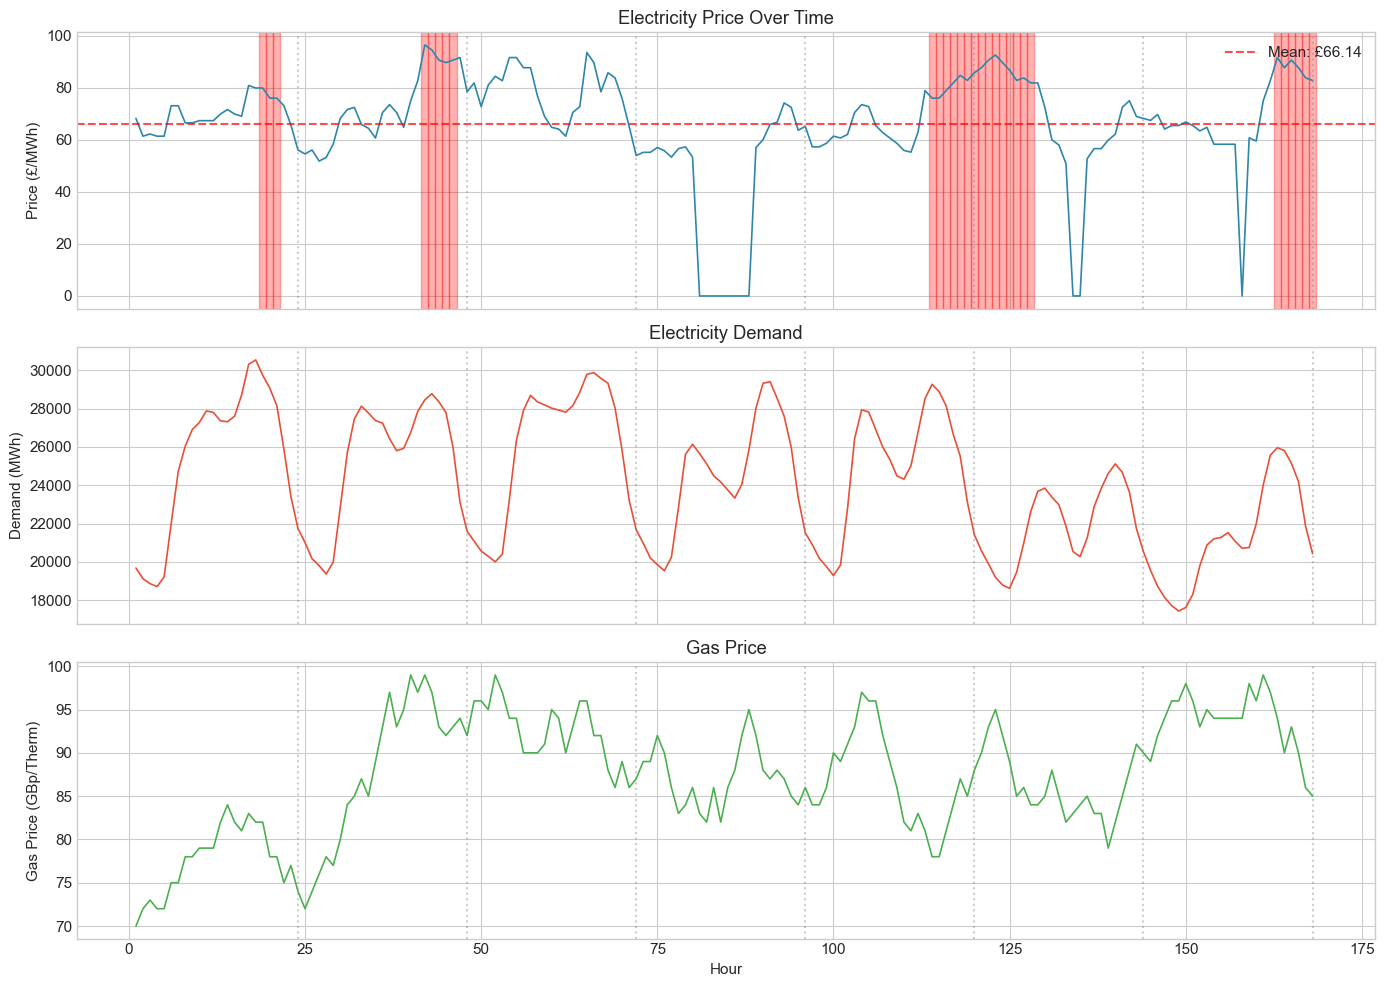

In [49]:
"""
Electricity Price Over Time

Shows how the marginal price varies across the 7-day simulation period.
Key patterns to observe: daily cycles, correlation with demand and gas prices.
"""

fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

hours = simulation_results['hour']

# Plot 1: Electricity price
ax1 = axes[0]
ax1.plot(hours, simulation_results['electricity_price'], color='#2E86AB', linewidth=1.2)
ax1.set_ylabel('Price (£/MWh)')
ax1.set_title('Electricity Price Over Time')
ax1.axhline(y=simulation_results['electricity_price'].mean(), color='red', 
            linestyle='--', alpha=0.7, label=f"Mean: £{simulation_results['electricity_price'].mean():.2f}")
ax1.legend(loc='upper right')

# Shade shortfall hours
for _, row in shortfall_hours.iterrows():
    ax1.axvspan(row['hour']-0.5, row['hour']+0.5, alpha=0.3, color='red')

# Plot 2: Demand for context
ax2 = axes[1]
ax2.plot(hours, simulation_results['demand'], color='#E94F37', linewidth=1.2)
ax2.set_ylabel('Demand (MWh)')
ax2.set_title('Electricity Demand')

# Plot 3: Gas price for context
ax3 = axes[2]
ax3.plot(hours, simulation_results['gas_price'], color='#4CAF50', linewidth=1.2)
ax3.set_ylabel('Gas Price (GBp/Therm)')
ax3.set_xlabel('Hour')
ax3.set_title('Gas Price')

# Add day markers
for ax in axes:
    for day in range(1, 8):
        ax.axvline(x=day*24, color='gray', linestyle=':', alpha=0.4)

plt.tight_layout()
plt.savefig('../results/02_electricity_price_over_time.png', dpi=150, bbox_inches='tight')
plt.show()

### 6.2 Generation Mix (Stacked Area Chart)

Gas generation (red) fills the gap between renewable output and demand. Solar follows a predictable daily cycle, while wind is more variable. The gap between the stacked area and the demand line represents unmet demand during shortfall hours.

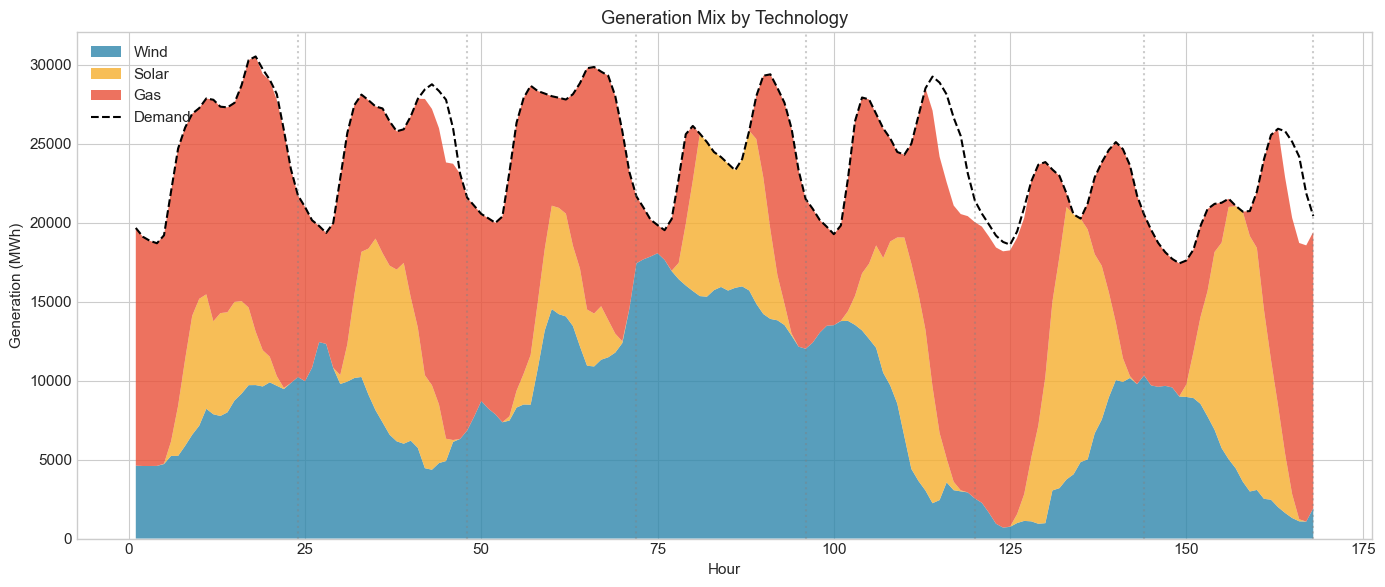

In [46]:
"""
Generation Mix Over Time

Stacked area chart showing the contribution of each technology (wind, solar, gas)
to meeting demand throughout the simulation period.
"""

fig, ax = plt.subplots(figsize=(14, 6))

hours = simulation_results['hour']
wind = simulation_results['wind_generation']
solar = simulation_results['solar_generation']
gas = simulation_results['gas_generation']

# Create stacked area chart
ax.stackplot(hours, wind, solar, gas,
             labels=['Wind', 'Solar', 'Gas'],
             colors=['#2E86AB', '#F6AE2D', '#E94F37'],
             alpha=0.8)

# Overlay demand line to show shortfalls
ax.plot(hours, simulation_results['demand'], color='black', linewidth=1.5, 
        linestyle='--', label='Demand')

ax.set_xlabel('Hour')
ax.set_ylabel('Generation (MWh)')
ax.set_title('Generation Mix by Technology')
ax.legend(loc='upper left')

# Add day markers
for day in range(1, 8):
    ax.axvline(x=day*24, color='gray', linestyle=':', alpha=0.4)

plt.tight_layout()
plt.savefig('../results/03_generation_mix.png', dpi=150, bbox_inches='tight')
plt.show()

### 6.3 Sample Hour - Merit Order Curve

The merit order curves show generators ranked by cost. Wind and solar bid at £0 but aren't visible as bars because their marginal cost is zero, which occupy the space from 0 to ~14,000 MW on the left chart. Gas plants form the visible cost stack, with the clearing price set where demand intersects supply. In Hour 116, demand exceeds total capacity, resulting in a 5,561 MWh shortfall.

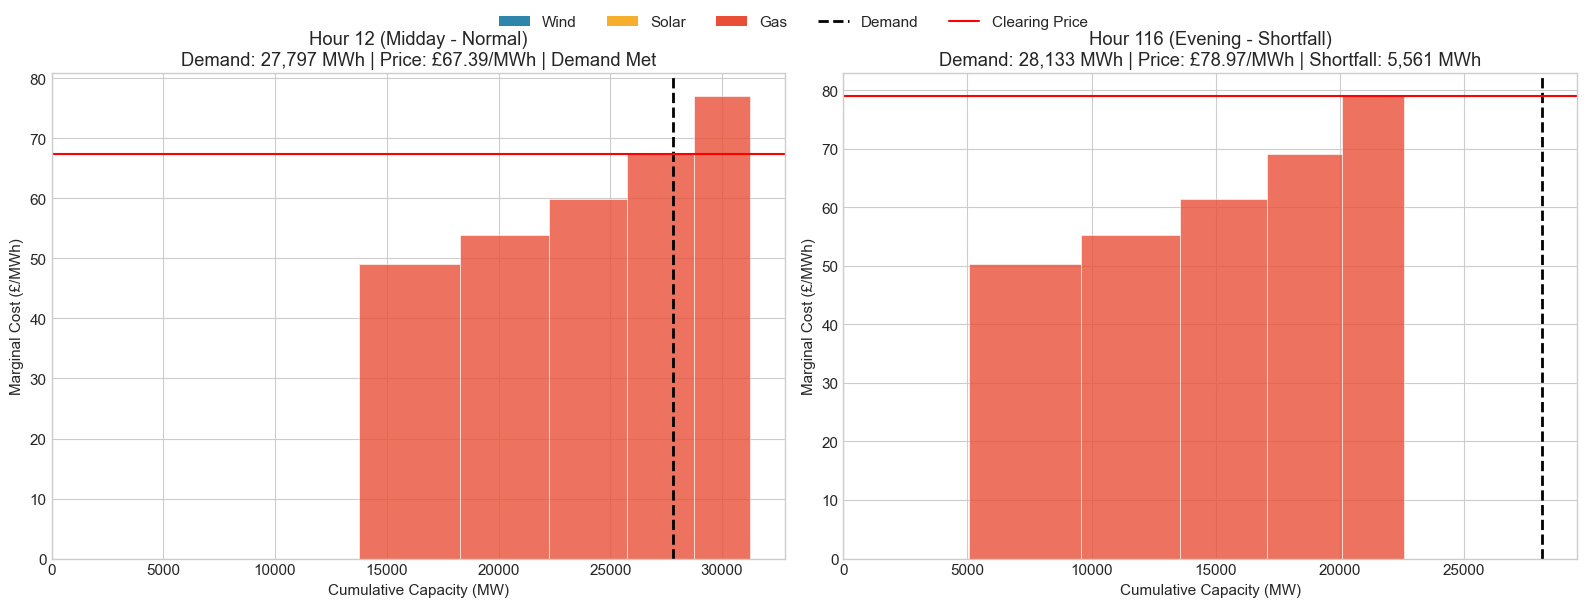

In [48]:
"""
Merit Order Curves

Two examples showing:
1. A normal hour where supply meets demand (Hour 12 - midday)
2. A shortfall hour where demand exceeds available capacity (Hour 116 - evening)
"""

def plot_merit_order_curve(hour: int, ax, title_suffix: str = ""):
    """
    Plot merit order curve for a specific hour.
    
    Returns the clearing price for annotation.
    """
    hour_gas_price = gas_prices.loc[hour - 1, 'price']
    hour_demand = demand.loc[hour - 1, 'demand']
    
    # Build merit order
    merit_order_viz = build_merit_order(
        wind_plants, wind_loadfactors,
        solar_plants, solar_loadfactors,
        gas_plants, hour_gas_price,
        hour
    )
    
    # Only include generators with available capacity > 0
    merit_order_viz = merit_order_viz[merit_order_viz['available_capacity'] > 0].copy()
    
    # Calculate cumulative capacity
    merit_order_viz['cumulative_start'] = merit_order_viz['available_capacity'].cumsum().shift(1).fillna(0)
    merit_order_viz['cumulative_end'] = merit_order_viz['available_capacity'].cumsum()
    
    # Draw bars for each generator
    colors = {'wind': '#2E86AB', 'solar': '#F6AE2D', 'gas': '#E94F37'}
    
    for _, row in merit_order_viz.iterrows():
        width = row['available_capacity']
        left = row['cumulative_start']
        height = row['marginal_cost']
        
        ax.bar(left + width/2, height, width=width, color=colors[row['type']], 
               edgecolor='white', linewidth=0.5, alpha=0.8)
    
    # Add demand line
    ax.axvline(x=hour_demand, color='black', linewidth=2, linestyle='--')
    
    # Find clearing price
    total_available = merit_order_viz['available_capacity'].sum()
    
    if hour_demand <= total_available:
        # Normal case - find marginal generator
        dispatched = merit_order_viz[merit_order_viz['cumulative_end'] <= hour_demand]
        if len(dispatched) < len(merit_order_viz):
            marginal_generator = merit_order_viz.iloc[len(dispatched)]
            clearing_price = marginal_generator['marginal_cost']
        else:
            clearing_price = merit_order_viz.iloc[-1]['marginal_cost']
        ax.axhline(y=clearing_price, color='red', linewidth=1.5, linestyle='-')
        status = "Demand Met"
    else:
        # Shortfall case
        clearing_price = merit_order_viz.iloc[-1]['marginal_cost']
        ax.axhline(y=clearing_price, color='red', linewidth=1.5, linestyle='-')
        shortfall = hour_demand - total_available
        status = f"Shortfall: {shortfall:,.0f} MWh"
    
    ax.set_xlabel('Cumulative Capacity (MW)')
    ax.set_ylabel('Marginal Cost (£/MWh)')
    ax.set_title(f'Hour {hour} {title_suffix}\nDemand: {hour_demand:,.0f} MWh | Price: £{clearing_price:.2f}/MWh | {status}')
    ax.set_ylim(bottom=0)
    ax.set_xlim(left=0)
    
    return clearing_price


# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Normal hour - midday with solar
plot_merit_order_curve(12, axes[0], "(Midday - Normal)")

# Shortfall hour - evening with high demand
plot_merit_order_curve(116, axes[1], "(Evening - Shortfall)")

# Add shared legend
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [
    Patch(facecolor='#2E86AB', label='Wind'),
    Patch(facecolor='#F6AE2D', label='Solar'),
    Patch(facecolor='#E94F37', label='Gas'),
    Line2D([0], [0], color='black', linewidth=2, linestyle='--', label='Demand'),
    Line2D([0], [0], color='red', linewidth=1.5, linestyle='-', label='Clearing Price')
]

fig.legend(handles=legend_elements, loc='upper center', ncol=5, bbox_to_anchor=(0.5, 1.02))

plt.tight_layout()
plt.savefig('../results/04_merit_order_curves.png', dpi=150, bbox_inches='tight')
plt.show()

---

## 7. Summary & Key Insights

**Price Dynamics**

The simulation produced an average electricity price of £66.14/MWh, ranging from £0 to £96.51/MWh. Gas plants set the marginal price in 94% of hours, which aligns closely with academic research showing gas sets UK wholesale prices approximately 98% of the time. The least efficient plant (gas1 at 35% efficiency) was the price-setter most frequently (27% of hours), reflecting real market behaviour where inefficient peaking plants are called upon during high demand periods. Prices dropped to £0 only when renewable generation alone was sufficient to meet demand.

**Generation Mix**

Renewables provided 55% of total generation across the week:
- Wind: 1,439,916 MWh (36.1%)
- Solar: 766,807 MWh (19.2%)
- Gas: 1,783,137 MWh (44.7%)

Solar output follows a predictable daily cycle with zero generation at night, while wind output is more variable but available around the clock. Despite renewables providing over half of generation, gas remains essential for system reliability during evening peaks and low-wind periods.

**Supply Constraints**

The simulation identified 29 hours (17%) where available generation capacity was insufficient to meet demand, resulting in 60,326 MWh of unmet demand. These shortfalls occurred primarily during evening hours when solar generation drops to zero and wind availability is low. This pattern matches real GB market behaviour: spare margin fell to just 580 MW on January 8, 2025, the tightest conditions since 2011.

In real electricity markets, these situations trigger mechanisms not modelled here: demand-side response, imports via interconnectors, and scarcity pricing where prices can spike to £5,000+/MWh. The GB market uses a Value of Lost Load (VoLL) of £6,000/MWh as the theoretical price ceiling during extreme scarcity events.

**Market Implications**

The results demonstrate the merit order effect: low marginal cost renewables are dispatched first, pushing expensive gas plants to the margin. This mechanism explains why UK electricity prices track gas prices closely - when gas sets the price 94% of hours, any gas price volatility passes directly through to consumers. Rising gas prices throughout the simulation week directly translated to higher electricity prices, illustrating why UK policy focuses on expanding renewables to reduce this gas-price dependency.